In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

# Objectif du notebook

Comparer les différentes modélisation possible sur la variable **production éolienne** :

* SARIMAX avec des fonctions sinusoïdales correspondant aux saisons observées en régresseurs exogènes
* SARIMAX avec des données métier en régresseurs exogènes (vent, pluie, différence de pression avec la mer, etc).
* SARIMAX avec des données métier FILTREES en régresseurs exogènes
* SARIMAX sur le signal filtré par transformation de Fourier sans régresseur
* SARIMAX sur le signal filtré avec des données métier FILTREES en régresseurs exogènes
* Régression linéaire sur les données métiers FILTREES comme variables explicatives
* Régression linéaire sur la variable à expliquée FILTREE et avec les variables explicatives FILTREES.

# Import du dataset original

In [2]:
df = pd.read_csv('./dataset/France_D.csv',
                usecols = ['Dates', 'Eolien'])
df.head(1)

,Dates,Eolien
0,2013-01-01,2613.7875


In [3]:
df['Dates'] = pd.to_datetime(df['Dates'], yearfirst = True)
df.set_index('Dates', inplace = True)

In [4]:
debut = dt.datetime(year = 2013, month = 1, day = 1)
fin = dt.datetime(year = 2020, month = 1, day = 1)

# Conversion en taux de charge pour annuler l'évolution dans le temps

In [5]:
capa = pd.read_csv('./datasource/capacite_eolien_FR.csv',
                  usecols = ['Dates', 'Capa_eol'])
capa['Dates'] = pd.to_datetime(capa['Dates'], format = '%Y/%m/%d %H:%M:%S', yearfirst = True)
capa.set_index('Dates', inplace = True)

In [6]:
capa = capa.resample('D').mean()

In [7]:
df = pd.concat([df, capa], axis = 1)
df['TCH_eol'] = df['Eolien'] / df['Capa_eol']
df

,Eolien,Capa_eol,TCH_eol
Dates,,,
2013-01-01,2613.787500,7519,0.347624
2013-01-02,1415.625000,7520,0.188248
2013-01-03,1608.895833,7523,0.213864
2013-01-04,1017.270833,7524,0.135203
2013-01-05,916.500000,7526,0.121778
...,...,...,...
2021-10-27,2214.958333,18558,0.119353
2021-10-28,6222.562500,18561,0.335249
2021-10-29,9517.625000,18563,0.512720


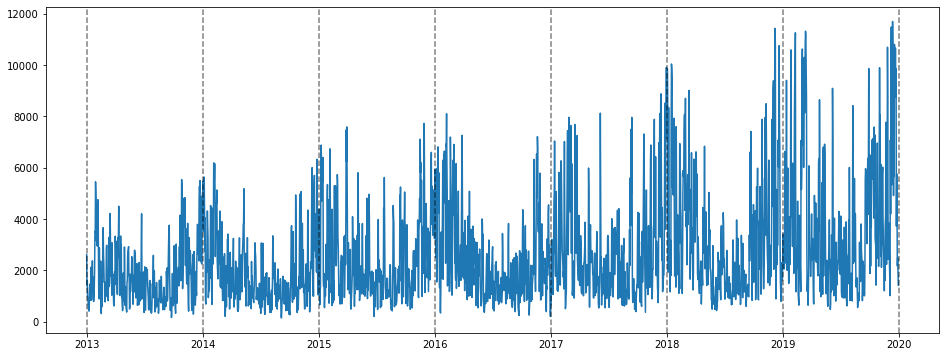

In [8]:
plt.figure(figsize=(16, 6))
plt.plot(df['Eolien'][(df.index >= debut) & (df.index < fin)])
for year in range(debut.year, fin.year + 1): 
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5);

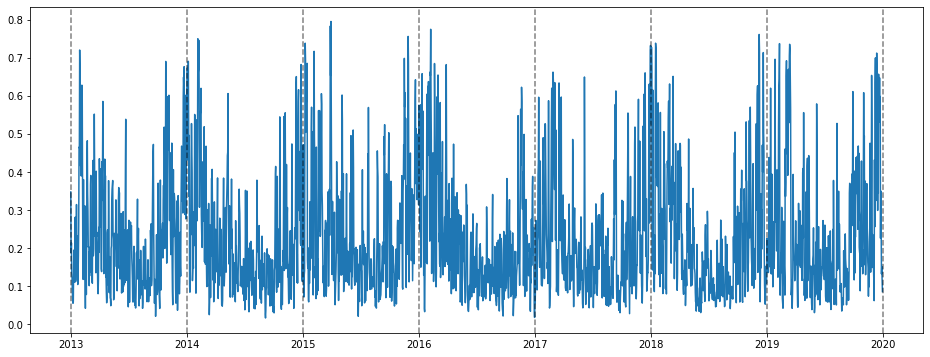

In [9]:
plt.figure(figsize=(16, 6))
plt.plot(df['TCH_eol'][(df.index >= debut) & (df.index < fin)])
for year in range(debut.year, fin.year + 1): 
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5);

### Test de stationnarité

In [10]:
# la 2ème valeur donne la p_value (stationnaire si < 5%)
sm.tsa.stattools.adfuller(df['TCH_eol'])

(-6.616423234237998,
 6.190870599057574e-09,
 23,
 3202,
 {'1%': -3.4323938944709473,
  '5%': -2.8624430687707174,
  '10%': -2.5672507236927578},
 -4576.487437729736)

### Coéfficients SARIMAX et saisonnalités

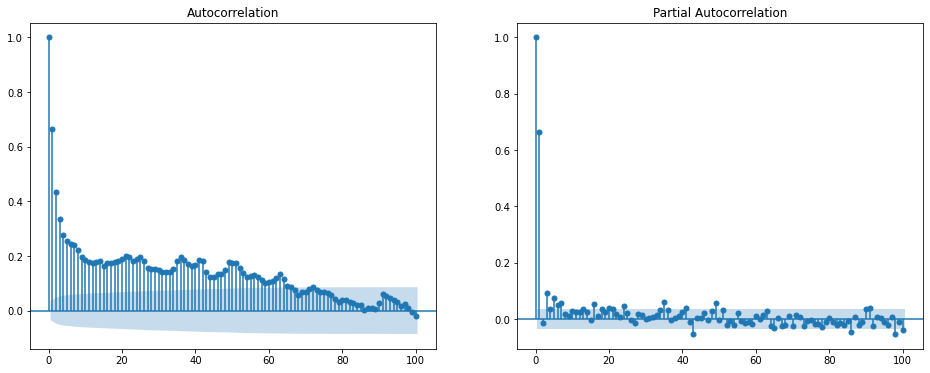

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
plot_acf(df['TCH_eol'], lags = 100, ax=ax1)
plot_pacf(df['TCH_eol'], lags = 100, ax=ax2)
plt.show()

**Saisonnalités :**
* néant

# Import du dataset filtré (Transformation de Fourier)

In [12]:
df_filtered = pd.read_csv('./dataset/France_D_filtered.csv',
                usecols = ['Dates', 'Eolien'])
df_filtered.head(1)

,Dates,Eolien
0,2013-01-01,3889.837808


In [13]:
df_filtered['Dates'] = pd.to_datetime(df_filtered['Dates'], yearfirst = True)
df_filtered.set_index('Dates', inplace = True)

In [14]:
df_filtered = pd.concat([df_filtered, capa], axis = 1)
df_filtered['TCH_eol'] = df_filtered['Eolien'] / df_filtered['Capa_eol']

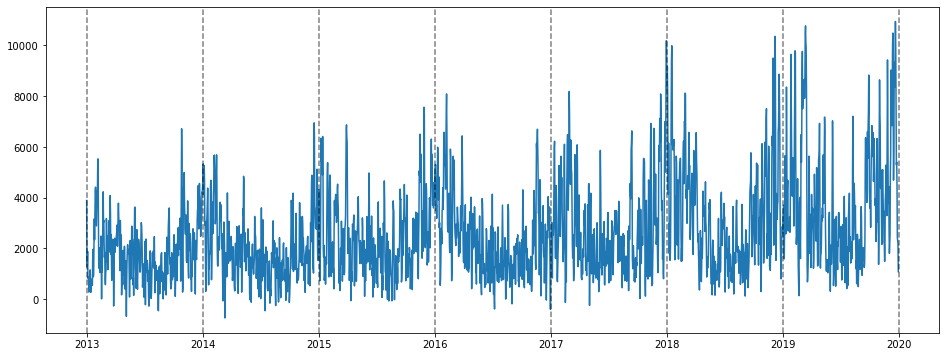

In [15]:
plt.figure(figsize=(16, 6))
plt.plot(df_filtered['Eolien'][(df.index >= debut) & (df.index < fin)])
for year in range(debut.year, fin.year + 1): 
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5);

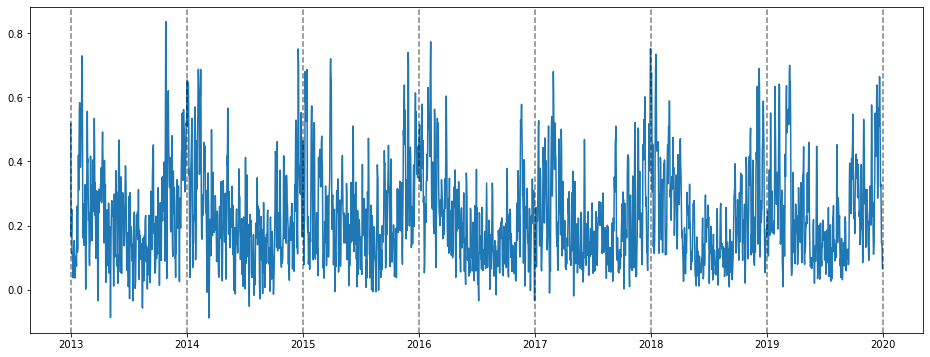

In [16]:
plt.figure(figsize=(16, 6))
plt.plot(df_filtered['TCH_eol'][(df.index >= debut) & (df.index < fin)])
for year in range(debut.year, fin.year + 1): 
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5);

# Jeux d'entrainement et de test

In [17]:
df_train = df[(df.index >= debut) & (df.index < fin)]
df_test = df[df.index >= fin]

In [18]:
df_train_filter = df_filtered[(df_filtered.index >= debut) & (df_filtered.index < fin)]
df_test_filter = df_filtered[df_filtered.index >= fin]

In [19]:
fenetre = df_test.shape[0]

In [20]:
indice = df_test.index

In [21]:
bilan = df_test

# Paramètres SARIMAX

In [22]:
ordre = (2,0,2)
saison = (0,0,0,365)

# Régresseurs exogènes : sinus & cosinus suivant les saisonnalités

In [23]:
exog = pd.DataFrame({'date': df.index})
exog['date'] = pd.to_datetime(exog['date'])
# suivant saisonnalités
# exog['sin_D'] = np.sin(2 * np.pi * exog.index / 8)
# exog['cos_D'] = np.cos(2 * np.pi * exog.index / 8)
# exog['sin_W'] = np.sin(2 * np.pi * exog.index / 7)
# exog['cos_W'] = np.cos(2 * np.pi * exog.index / 7)
exog['sin_Y'] = np.sin(2 * np.pi * exog.index / 365.25)
exog['cos_Y'] = np.cos(2 * np.pi * exog.index / 365.25)
exog.set_index('date', inplace = True)

In [24]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

<ipython-input-25-56416ee0eedf>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  plt.plot(exog[(exog.index >= pd.datetime(2016, 1, 1)) & (exog.index < pd.datetime(2016, 1, 15))])


''

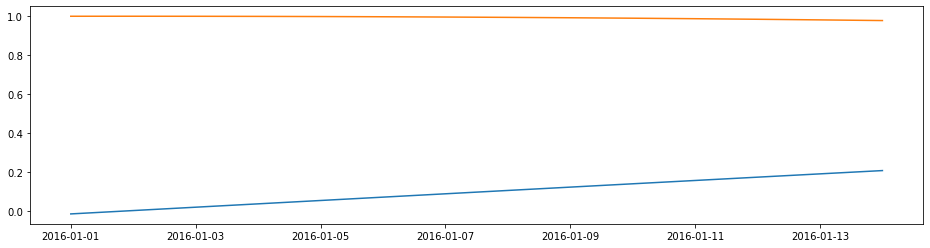

In [25]:
plt.figure(figsize=(16, 4))
plt.plot(exog[(exog.index >= pd.datetime(2016, 1, 1)) & (exog.index < pd.datetime(2016, 1, 15))])
# for year in range(debut.year, fin.year + 1): 
#     plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)
;

### SARIMAX

In [26]:
model_sinus = sm.tsa.SARIMAX(df_train['TCH_eol'].values,
                             exog = exog_train.values,
                             order = ordre,
                             seasonal_order = saison)
result_sinus = model_sinus.fit()

C:\Python\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [27]:
predict_sinus = result_sinus.predict(start = 1 ,
                                     end = fenetre,
                                     exog = exog_test.values)

In [28]:
predict_sinus = pd.DataFrame(predict_sinus, columns=['Eol_p_sinus'], index = indice)

In [29]:
bilan = pd.concat([bilan, predict_sinus], axis = 1)

### Erreur absolue

In [30]:
bilan['Err_sinus'] = np.abs(bilan['Eol_p_sinus'] - bilan['TCH_eol'])
bilan.describe()

,Eolien,Capa_eol,TCH_eol,Eol_p_sinus,Err_sinus
count,670.000000,670.000000,670.000000,670.000000,670.000000
mean,4270.149689,17517.977612,0.245102,0.206974,0.129488
std,2897.733460,599.630767,0.168290,0.103777,0.118434
min,378.500000,16494.000000,0.020671,0.063986,0.000095
25%,1972.947917,17000.250000,0.111882,0.126312,0.042223
50%,3461.802083,17507.000000,0.196429,0.177637,0.091701
75%,5984.265625,18035.500000,0.337450,0.265162,0.183068
max,13574.875000,18570.000000,0.761436,0.573975,0.617725


# Régresseurs exogènes : données métier

In [31]:
exog = pd.read_csv('./exog/exog_D_FR.csv', sep = ';',
                   usecols = ['Dates', 'Vent', 'Humidite', 'Pluie_eol', 'Temperature_eol', 'Diff_pression'])
exog.head(1)

,Dates,Vent,Humidite,Pluie_eol,Temperature_eol,Diff_pression
0,2013-01-01,4.472572,85.153043,0.551527,7.41252,-1292.672452


In [32]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [33]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

### SARIMAX

In [34]:
model_exog = sm.tsa.SARIMAX(df_train['TCH_eol'].values,
                       exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [35]:
result_exog = model_exog.fit(low_memory=True)

C:\Python\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Python\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [36]:
result_exog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2556
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -82605.689
Date:                Wed, 04 May 2022   AIC                         165231.377
Time:                        10:26:35   BIC                         165289.839
Sample:                             0   HQIC                        165252.578
                               - 2556                                         
Covariance Type:               approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1120      0.000    805.242      0.000       0.112       0.112
x2             0.0007   1.77e-05     39.374      0.000       0.001       0.001
x3            -0.0106      0.001    -13.967      0.000      -0.012      -0.009
x4            -0.0030   1.49e-05   -204.635      0.000      -0.003      -0.003
x5             0.0002   1.24e-06    130.740      0.000       0.000       0.000
ar.L1           1e-11      0.020   5.09e-10      1.000      -0.038       0.038
ar.L2       9.856e-12      0.020   4.86e-10      1.000      -0.040       0.040
ma.L1         -0.8362      0.006   -148.450      0.000      -0.847      -0.825
ma.L2         -0.1015      0.006    -17.622      0.000      -0.113      -0.090
sigma2         0.0017   5.18e-06    322.100      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                2515.88   Jarque-Bera (JB):                71.77
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                             0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [37]:
predict_exog = result_exog.predict(start = 1 ,
                               end = fenetre,
                               exog = exog_test.values)

In [38]:
predict_exog = pd.DataFrame(predict_exog, index = indice, columns = ['Eol_p_exog'])

In [39]:
bilan = pd.concat([bilan, predict_exog], axis = 1)

### Erreur absolue

In [40]:
bilan['Err_exog'] = np.abs(bilan['Eol_p_exog'] - bilan['TCH_eol'])
bilan.describe()

,Eolien,Capa_eol,TCH_eol,Eol_p_sinus,Err_sinus,Eol_p_exog,Err_exog
count,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000
mean,4270.149689,17517.977612,0.245102,0.206974,0.129488,0.317025,0.306966
std,2897.733460,599.630767,0.168290,0.103777,0.118434,0.329069,0.218282
min,378.500000,16494.000000,0.020671,0.063986,0.000095,-0.523791,0.000460
25%,1972.947917,17000.250000,0.111882,0.126312,0.042223,0.086052,0.132616
50%,3461.802083,17507.000000,0.196429,0.177637,0.091701,0.309140,0.267662
75%,5984.265625,18035.500000,0.337450,0.265162,0.183068,0.526608,0.442354
max,13574.875000,18570.000000,0.761436,0.573975,0.617725,1.227459,1.142476


# Régresseurs exogènes : données métier FILTREES

In [41]:
exog = pd.read_csv('./exog/exog_D_FR_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'Vent', 'Humidite', 'Pluie_eol', 'Temperature_eol', 'Diff_pression'])
exog.head(1)

,Dates,Vent,Humidite,Pluie_eol,Temperature_eol,Diff_pression
0,2013-01-01,4.657828,84.693781,0.620244,7.459363,-1291.680752


In [42]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [43]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

### SARIMAX

In [44]:
model_filter = sm.tsa.SARIMAX(df_train['TCH_eol'].values,
                       exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [45]:
result_filter = model_filter.fit(low_memory=True)

In [46]:
result_filter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2556
Model:               SARIMAX(2, 0, 2)   Log Likelihood                3443.165
Date:                Wed, 04 May 2022   AIC                          -6866.330
Time:                        10:26:40   BIC                          -6807.868
Sample:                             0   HQIC                         -6845.129
                               - 2556                                         
Covariance Type:               approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1096      0.001     83.319      0.000       0.107       0.112
x2            -0.0024      0.000     -9.078      0.000      -0.003      -0.002
x3             0.0153      0.005      2.983      0.003       0.005       0.025
x4            -0.0014      0.001     -2.484      0.013      -0.003      -0.000
x5          -1.67e-05   1.84e-05     -0.908      0.364   -5.28e-05    1.94e-05
ar.L1          0.8751        nan        nan        nan         nan         nan
ar.L2          0.1063        nan        nan        nan         nan         nan
ma.L1         -0.7428        nan        nan        nan         nan         nan
ma.L2         -0.1390        nan        nan        nan         nan         nan
sigma2         0.0042      0.000     30.610      0.000       0.004       0.004
===================================================================================
Ljung-Box (L1) (Q):                   5.97   Jarque-Bera (JB):                26.32
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                             0.12
Prob(H) (two-sided):                  0.75   Kurtosis:                         3.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [47]:
predict_filter = result_filter.predict(start = 1 ,
                               end = fenetre,
                               exog = exog_test.values)

In [48]:
predict_filter = pd.DataFrame(predict_filter, index = indice, columns = ['Eol_p_filter'])

In [49]:
bilan = pd.concat([bilan, predict_filter], axis = 1)

### Erreur absolue

In [50]:
bilan['Err_exog_filter'] = np.abs(bilan['Eol_p_filter'] - bilan['TCH_eol'])
bilan.describe()

,Eolien,Capa_eol,TCH_eol,Eol_p_sinus,Err_sinus,Eol_p_exog,Err_exog,Eol_p_filter,Err_exog_filter
count,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000
mean,4270.149689,17517.977612,0.245102,0.206974,0.129488,0.317025,0.306966,0.225112,0.144660
std,2897.733460,599.630767,0.168290,0.103777,0.118434,0.329069,0.218282,0.144984,0.124157
min,378.500000,16494.000000,0.020671,0.063986,0.000095,-0.523791,0.000460,-0.037875,0.000718
25%,1972.947917,17000.250000,0.111882,0.126312,0.042223,0.086052,0.132616,0.119803,0.052997
50%,3461.802083,17507.000000,0.196429,0.177637,0.091701,0.309140,0.267662,0.197936,0.109171
75%,5984.265625,18035.500000,0.337450,0.265162,0.183068,0.526608,0.442354,0.301901,0.204824
max,13574.875000,18570.000000,0.761436,0.573975,0.617725,1.227459,1.142476,0.901849,0.763767


# Target FILTREE sans régresseur

### SARIMAX

In [51]:
model_reduit_noreg = sm.tsa.SARIMAX(df_train_filter['TCH_eol'].values,
                       # exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [52]:
result_reduit_noreg = model_reduit_noreg.fit(low_memory=True)

C:\Python\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Python\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [53]:
result_reduit_noreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2556
Model:               SARIMAX(2, 0, 2)   Log Likelihood                2605.176
Date:                Wed, 04 May 2022   AIC                          -5200.352
Time:                        10:26:44   BIC                          -5171.121
Sample:                             0   HQIC                         -5189.752
                               - 2556                                         
Covariance Type:               approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3795        nan        nan        nan         nan         nan
ar.L2         -0.3858        nan        nan        nan         nan         nan
ma.L1         -0.2894        nan        nan        nan         nan         nan
ma.L2         -0.5328      0.015    -36.289      0.000      -0.562      -0.504
sigma2         0.0075      0.000     37.114      0.000       0.007       0.008
===================================================================================
Ljung-Box (L1) (Q):                   3.97   Jarque-Bera (JB):                13.85
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [54]:
predict_reduit_noreg = result_reduit_noreg.predict(start = 1 ,
                               end = fenetre,
                               # exog = exog_test.values
                            )

In [55]:
predict_reduit_noreg = pd.DataFrame(predict_reduit_noreg, index = indice, columns = ['Eol_p_reduit_noreg'])

In [56]:
bilan = pd.concat([bilan, predict_reduit_noreg], axis = 1)

### Erreur absolue

In [57]:
bilan['Err_filter_noreg'] = np.abs(bilan['Eol_p_reduit_noreg'] - bilan['TCH_eol'])
bilan.describe()

,Eolien,Capa_eol,TCH_eol,Eol_p_sinus,Err_sinus,Eol_p_exog,Err_exog,Eol_p_filter,Err_exog_filter,Eol_p_reduit_noreg,Err_filter_noreg
count,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000
mean,4270.149689,17517.977612,0.245102,0.206974,0.129488,0.317025,0.306966,0.225112,0.144660,0.217368,0.148836
std,2897.733460,599.630767,0.168290,0.103777,0.118434,0.329069,0.218282,0.144984,0.124157,0.133947,0.126509
min,378.500000,16494.000000,0.020671,0.063986,0.000095,-0.523791,0.000460,-0.037875,0.000718,-0.125084,0.000314
25%,1972.947917,17000.250000,0.111882,0.126312,0.042223,0.086052,0.132616,0.119803,0.052997,0.119900,0.055202
50%,3461.802083,17507.000000,0.196429,0.177637,0.091701,0.309140,0.267662,0.197936,0.109171,0.194929,0.113300
75%,5984.265625,18035.500000,0.337450,0.265162,0.183068,0.526608,0.442354,0.301901,0.204824,0.298573,0.213014
max,13574.875000,18570.000000,0.761436,0.573975,0.617725,1.227459,1.142476,0.901849,0.763767,0.751984,0.884593


# Target FILTREE avec Régresseurs exogènes : données métier FILTREES

In [58]:
exog = pd.read_csv('./exog/exog_D_FR_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'Vent', 'Humidite', 'Pluie_eol', 'Temperature_eol', 'Diff_pression'])
exog.head(1)

,Dates,Vent,Humidite,Pluie_eol,Temperature_eol,Diff_pression
0,2013-01-01,4.657828,84.693781,0.620244,7.459363,-1291.680752


In [59]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [60]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

### SARIMAX

In [61]:
model_reduit = sm.tsa.SARIMAX(df_train_filter['TCH_eol'].values,
                       exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [62]:
result_reduit = model_reduit.fit(low_memory=True)

C:\Python\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [63]:
result_reduit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2556
Model:               SARIMAX(2, 0, 2)   Log Likelihood                3667.746
Date:                Wed, 04 May 2022   AIC                          -7315.491
Time:                        10:26:48   BIC                          -7257.029
Sample:                             0   HQIC                         -7294.291
                               - 2556                                         
Covariance Type:               approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1020      0.001     69.925      0.000       0.099       0.105
x2             0.0006      0.000      1.733      0.083    -8.5e-05       0.001
x3            -0.0061      0.005     -1.318      0.187      -0.015       0.003
x4            -0.0036      0.001     -6.520      0.000      -0.005      -0.003
x5             0.0001   2.19e-05      5.725      0.000    8.23e-05       0.000
ar.L1          0.5418      0.292      1.853      0.064      -0.031       1.115
ar.L2          0.1784      0.053      3.393      0.001       0.075       0.281
ma.L1          0.0316      0.300      0.105      0.916      -0.557       0.620
ma.L2         -0.4284      0.147     -2.907      0.004      -0.717      -0.140
sigma2         0.0033   9.71e-05     34.138      0.000       0.003       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                12.12
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                            -0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [64]:
predict_reduit = result_reduit.predict(start = 1 ,
                               end = fenetre,
                               exog = exog_test.values)

In [65]:
predict_reduit = pd.DataFrame(predict_reduit, index = indice, columns = ['Eol_p_reduit'])

In [66]:
bilan = pd.concat([bilan, predict_reduit], axis = 1)

### Erreur absolue

In [67]:
bilan['Err_filter_exog_filter'] = np.abs(bilan['Eol_p_reduit'] - bilan['TCH_eol'])
bilan.describe()

,Eolien,Capa_eol,TCH_eol,Eol_p_sinus,Err_sinus,Eol_p_exog,Err_exog,Eol_p_filter,Err_exog_filter,Eol_p_reduit_noreg,Err_filter_noreg,Eol_p_reduit,Err_filter_exog_filter
count,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000
mean,4270.149689,17517.977612,0.245102,0.206974,0.129488,0.317025,0.306966,0.225112,0.144660,0.217368,0.148836,0.227417,0.143380
std,2897.733460,599.630767,0.168290,0.103777,0.118434,0.329069,0.218282,0.144984,0.124157,0.133947,0.126509,0.139551,0.124515
min,378.500000,16494.000000,0.020671,0.063986,0.000095,-0.523791,0.000460,-0.037875,0.000718,-0.125084,0.000314,-0.074835,0.000006
25%,1972.947917,17000.250000,0.111882,0.126312,0.042223,0.086052,0.132616,0.119803,0.052997,0.119900,0.055202,0.127516,0.047135
50%,3461.802083,17507.000000,0.196429,0.177637,0.091701,0.309140,0.267662,0.197936,0.109171,0.194929,0.113300,0.206049,0.108825
75%,5984.265625,18035.500000,0.337450,0.265162,0.183068,0.526608,0.442354,0.301901,0.204824,0.298573,0.213014,0.307715,0.207904
max,13574.875000,18570.000000,0.761436,0.573975,0.617725,1.227459,1.142476,0.901849,0.763767,0.751984,0.884593,0.757701,0.834344


# Régression linéaire avec Régresseurs exogènes : données métier FILTREES 

In [68]:
exog = pd.read_csv('./exog/exog_D_FR_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'Vent', 'Humidite', 'Pluie_eol', 'Temperature_eol', 'Diff_pression'])
exog.head(1)

,Dates,Vent,Humidite,Pluie_eol,Temperature_eol,Diff_pression
0,2013-01-01,4.657828,84.693781,0.620244,7.459363,-1291.680752


In [69]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [70]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

In [71]:
LinReg = LinearRegression()
LinReg.fit(exog_train, df_train['TCH_eol'])
predict_lr = LinReg.predict(exog_test)

In [72]:
predict_lr = pd.DataFrame(predict_lr, index = indice, columns = ['Eol_p_LinReg'])

In [73]:
bilan = pd.concat([bilan, predict_lr], axis = 1)

### Erreur absolue

In [74]:
bilan['Err_LinReg'] = np.abs(bilan['Eol_p_LinReg'] - bilan['TCH_eol'])
bilan.describe()

,Eolien,Capa_eol,TCH_eol,Eol_p_sinus,Err_sinus,Eol_p_exog,Err_exog,Eol_p_filter,Err_exog_filter,Eol_p_reduit_noreg,Err_filter_noreg,Eol_p_reduit,Err_filter_exog_filter,Eol_p_LinReg,Err_LinReg
count,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000
mean,4270.149689,17517.977612,0.245102,0.206974,0.129488,0.317025,0.306966,0.225112,0.144660,0.217368,0.148836,0.227417,0.143380,0.241119,0.056267
std,2897.733460,599.630767,0.168290,0.103777,0.118434,0.329069,0.218282,0.144984,0.124157,0.133947,0.126509,0.139551,0.124515,0.151993,0.043724
min,378.500000,16494.000000,0.020671,0.063986,0.000095,-0.523791,0.000460,-0.037875,0.000718,-0.125084,0.000314,-0.074835,0.000006,-0.048275,0.000743
25%,1972.947917,17000.250000,0.111882,0.126312,0.042223,0.086052,0.132616,0.119803,0.052997,0.119900,0.055202,0.127516,0.047135,0.129818,0.021429
50%,3461.802083,17507.000000,0.196429,0.177637,0.091701,0.309140,0.267662,0.197936,0.109171,0.194929,0.113300,0.206049,0.108825,0.215568,0.047632
75%,5984.265625,18035.500000,0.337450,0.265162,0.183068,0.526608,0.442354,0.301901,0.204824,0.298573,0.213014,0.307715,0.207904,0.324589,0.081582
max,13574.875000,18570.000000,0.761436,0.573975,0.617725,1.227459,1.142476,0.901849,0.763767,0.751984,0.884593,0.757701,0.834344,0.954534,0.229534


# Régression linéaire sur target FILTREE avec Régresseurs exogènes : données métier FILTREES 

In [75]:
exog = pd.read_csv('./exog/exog_D_FR_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'Vent', 'Humidite', 'Pluie_eol', 'Temperature_eol', 'Diff_pression'])
exog.head(1)

,Dates,Vent,Humidite,Pluie_eol,Temperature_eol,Diff_pression
0,2013-01-01,4.657828,84.693781,0.620244,7.459363,-1291.680752


In [76]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [77]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

In [78]:
LinReg_filter = LinearRegression()
LinReg_filter.fit(exog_train, df_train_filter['TCH_eol'])
predict_lr_filter = LinReg_filter.predict(exog_test)

In [79]:
predict_lr_filter = pd.DataFrame(predict_lr_filter, index = indice, columns = ['Eol_p_LinReg_filter'])

In [80]:
bilan = pd.concat([bilan, predict_lr_filter], axis = 1)

### Erreur absolue

In [81]:
bilan['Err_LinReg_filter'] = np.abs(bilan['Eol_p_LinReg_filter'] - bilan['TCH_eol'])
bilan.describe()

,Eolien,Capa_eol,TCH_eol,Eol_p_sinus,Err_sinus,Eol_p_exog,Err_exog,Eol_p_filter,Err_exog_filter,Eol_p_reduit_noreg,Err_filter_noreg,Eol_p_reduit,Err_filter_exog_filter,Eol_p_LinReg,Err_LinReg,Eol_p_LinReg_filter,Err_LinReg_filter
count,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000
mean,4270.149689,17517.977612,0.245102,0.206974,0.129488,0.317025,0.306966,0.225112,0.144660,0.217368,0.148836,0.227417,0.143380,0.241119,0.056267,0.239976,0.056378
std,2897.733460,599.630767,0.168290,0.103777,0.118434,0.329069,0.218282,0.144984,0.124157,0.133947,0.126509,0.139551,0.124515,0.151993,0.043724,0.140879,0.044822
min,378.500000,16494.000000,0.020671,0.063986,0.000095,-0.523791,0.000460,-0.037875,0.000718,-0.125084,0.000314,-0.074835,0.000006,-0.048275,0.000743,-0.030699,0.000036
25%,1972.947917,17000.250000,0.111882,0.126312,0.042223,0.086052,0.132616,0.119803,0.052997,0.119900,0.055202,0.127516,0.047135,0.129818,0.021429,0.136984,0.019327
50%,3461.802083,17507.000000,0.196429,0.177637,0.091701,0.309140,0.267662,0.197936,0.109171,0.194929,0.113300,0.206049,0.108825,0.215568,0.047632,0.217026,0.048066
75%,5984.265625,18035.500000,0.337450,0.265162,0.183068,0.526608,0.442354,0.301901,0.204824,0.298573,0.213014,0.307715,0.207904,0.324589,0.081582,0.319042,0.080156
max,13574.875000,18570.000000,0.761436,0.573975,0.617725,1.227459,1.142476,0.901849,0.763767,0.751984,0.884593,0.757701,0.834344,0.954534,0.229534,0.893656,0.233551


# Calcul de la prediction : TCH x Capacité

In [82]:
bilan['Eol_p_sinus'] = bilan['Eol_p_sinus'] * bilan['Capa_eol']
bilan['Err_sinus'] = bilan['Err_sinus'] * bilan['Capa_eol']
bilan['Eol_p_exog'] = bilan['Eol_p_exog'] * bilan['Capa_eol']
bilan['Err_exog'] = bilan['Err_exog'] * bilan['Capa_eol']
bilan['Eol_p_filter'] = bilan['Eol_p_filter'] * bilan['Capa_eol']
bilan['Err_exog_filter'] = bilan['Err_exog_filter'] * bilan['Capa_eol']
bilan['Eol_p_reduit_noreg'] = bilan['Eol_p_reduit_noreg'] * bilan['Capa_eol']
bilan['Err_filter_noreg'] = bilan['Err_filter_noreg'] * bilan['Capa_eol']
bilan['Eol_p_reduit'] = bilan['Eol_p_reduit'] * bilan['Capa_eol']
bilan['Err_filter_exog_filter'] = bilan['Err_filter_exog_filter'] * bilan['Capa_eol']
bilan['Eol_p_LinReg'] = bilan['Eol_p_LinReg'] * bilan['Capa_eol']
bilan['Err_LinReg'] = bilan['Err_LinReg'] * bilan['Capa_eol']
bilan['Eol_p_LinReg_filter'] = bilan['Eol_p_LinReg_filter'] * bilan['Capa_eol']
bilan['Err_LinReg_filter'] = bilan['Err_LinReg_filter'] * bilan['Capa_eol']
bilan.describe()

,Eolien,Capa_eol,TCH_eol,Eol_p_sinus,Err_sinus,Eol_p_exog,Err_exog,Eol_p_filter,Err_exog_filter,Eol_p_reduit_noreg,Err_filter_noreg,Eol_p_reduit,Err_filter_exog_filter,Eol_p_LinReg,Err_LinReg,Eol_p_LinReg_filter,Err_LinReg_filter
count,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000
mean,4270.149689,17517.977612,0.245102,3619.354730,2254.348353,5460.076766,5354.534166,3930.965919,2522.763033,3795.998218,2595.661613,3969.301179,2500.809168,4205.134510,984.929860,4185.920357,986.758367
std,2897.733460,599.630767,0.168290,1811.369758,2042.783641,5616.788082,3761.239889,2526.923517,2151.130390,2327.185209,2187.143538,2422.613919,2156.344108,2615.515422,764.498044,2421.498702,783.474094
min,378.500000,16494.000000,0.020671,1163.528143,1.645376,-9230.766316,7.876261,-655.205467,12.081913,-2229.255793,5.327765,-1333.712022,0.098682,-883.969596,12.823194,-562.129288,0.618213
25%,1972.947917,17000.250000,0.111882,2207.799179,738.998916,1541.608695,2303.714233,2117.170621,923.948468,2135.695269,960.947224,2221.759293,848.820421,2302.489780,370.345873,2409.266962,339.003478
50%,3461.802083,17507.000000,0.196429,3100.343064,1593.459921,5436.439906,4692.135393,3452.116129,1926.992147,3421.830791,1986.392030,3607.212885,1956.943211,3771.624184,831.086782,3777.155511,836.759724
75%,5984.265625,18035.500000,0.337450,4607.524025,3198.297855,9377.600337,7821.343461,5316.655902,3638.857101,5277.658765,3747.026892,5333.102247,3584.273444,5664.434783,1425.852781,5501.215599,1387.302106
max,13574.875000,18570.000000,0.761436,10165.098329,10617.857559,20518.211049,20361.207262,15846.397451,13611.848301,13083.767490,15765.214126,13313.564040,14869.670356,15858.621808,4094.196930,14847.206633,4107.410658


# Visualisation réel vs prédictions

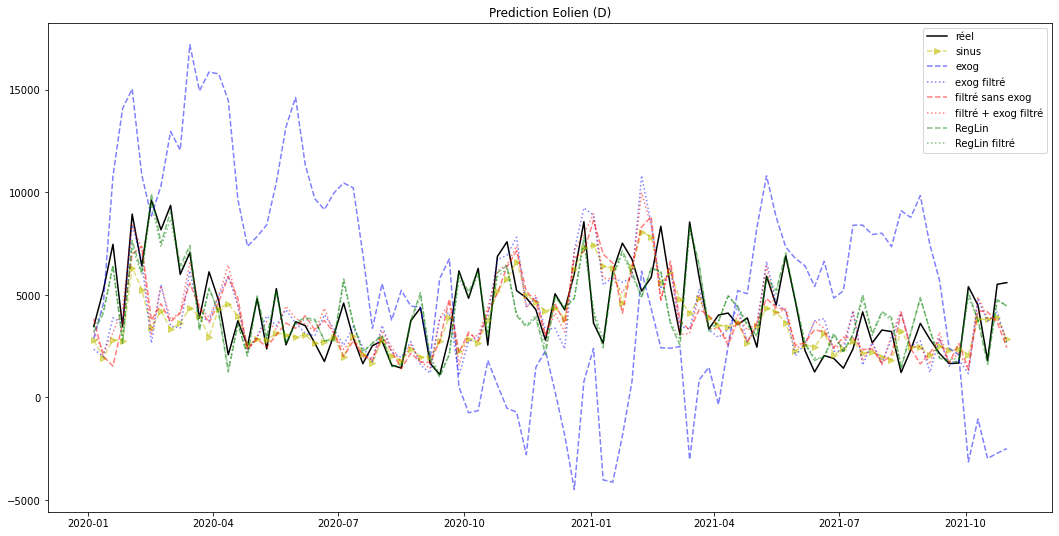

In [83]:
plt.figure(figsize=(18,9))
plt.plot(bilan['Eolien'].resample('W').mean(), color = 'k', label = 'réel')
plt.plot(bilan['Eol_p_sinus'].resample('W').mean(), color = 'y', linestyle = '--', alpha = 0.5, label = 'sinus', marker = '>')
plt.plot(bilan['Eol_p_exog'].resample('W').mean(), color = 'b', linestyle = '--', alpha = 0.5, label = 'exog')
plt.plot(bilan['Eol_p_filter'].resample('W').mean(), color = 'b', linestyle = ':', alpha = 0.5, label = 'exog filtré')
plt.plot(bilan['Eol_p_reduit_noreg'].resample('W').mean(), color = 'r', linestyle = '--', alpha = 0.5, label = 'filtré sans exog')
plt.plot(bilan['Eol_p_reduit'].resample('W').mean(), color = 'r', linestyle = ':', alpha = 0.5, label = 'filtré + exog filtré')
plt.plot(bilan['Eol_p_LinReg'].resample('W').mean(), color = 'g', linestyle = '--', alpha = 0.5, label = 'RegLin')
plt.plot(bilan['Eol_p_LinReg_filter'].resample('W').mean(), color = 'g', linestyle = ':', alpha = 0.5, label = 'RegLin filtré')
plt.legend(loc = 'upper right')
plt.title('Prediction Eolien (D)')
plt.savefig('./results/pred_eolien_D.png');

# Synthèse des erreurs

In [85]:
erreur = bilan[['Err_sinus',
       'Err_exog',
       'Err_exog_filter',
       'Err_filter_noreg',
       'Err_filter_exog_filter',
       'Err_LinReg',
       'Err_LinReg_filter'
      ]].describe()
erreur

,Err_sinus,Err_exog,Err_exog_filter,Err_filter_noreg,Err_filter_exog_filter,Err_LinReg,Err_LinReg_filter
count,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000
mean,2254.348353,5354.534166,2522.763033,2595.661613,2500.809168,984.929860,986.758367
std,2042.783641,3761.239889,2151.130390,2187.143538,2156.344108,764.498044,783.474094
min,1.645376,7.876261,12.081913,5.327765,0.098682,12.823194,0.618213
25%,738.998916,2303.714233,923.948468,960.947224,848.820421,370.345873,339.003478
50%,1593.459921,4692.135393,1926.992147,1986.392030,1956.943211,831.086782,836.759724
75%,3198.297855,7821.343461,3638.857101,3747.026892,3584.273444,1425.852781,1387.302106
max,10617.857559,20361.207262,13611.848301,15765.214126,14869.670356,4094.196930,4107.410658


In [86]:
exog_test.columns

Index(['Vent', 'Humidite', 'Pluie_eol', 'Temperature_eol', 'Diff_pression'], dtype='object')

In [87]:
LinReg.coef_

array([ 0.11082495,  0.00059888,  0.01708846, -0.00148366, -0.00012976])

In [88]:
bilan.to_csv('./results/bilan_eolien_D.csv', sep = ';')
erreur.to_csv('./results/erreur_eolien_D.csv', sep = ';')